In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer  # for unsupervised binning
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

In [4]:
df.dropna(inplace=True)

In [5]:
df.shape

(714, 3)

In [6]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [7]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
X_train.head(2)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542


# without encoding numerical data

In [10]:
clf = DecisionTreeClassifier()

In [11]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [12]:
accuracy_score(y_test,y_pred)

0.6363636363636364

In [13]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

np.float64(0.6331181533646323)

# applying uniform(eqaul width) binning

In [14]:
kbin_age = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='uniform')  # output will be in ordinal encoding
kbin_fare = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='uniform')

In [16]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
])

In [17]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [19]:
trf.named_transformers_['first'].bin_edges_    # binning boundries for age

array([array([ 0.42      ,  5.72533333, 11.03066667, 16.336     , 21.64133333,
              26.94666667, 32.252     , 37.55733333, 42.86266667, 48.168     ,
              53.47333333, 58.77866667, 64.084     , 69.38933333, 74.69466667,
              80.        ])                                                   ],
      dtype=object)

In [21]:
trf.named_transformers_['second'].bin_edges_  # for fare

array([array([  0.     ,  34.15528,  68.31056, 102.46584, 136.62112, 170.7764 ,
              204.93168, 239.08696, 273.24224, 307.39752, 341.5528 , 375.70808,
              409.86336, 444.01864, 478.17392, 512.3292 ])                     ],
      dtype=object)

In [22]:
output = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

In [23]:
output['age_labels'] = pd.cut(x=X_train['Age'],
                                    bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],
                                    bins=trf.named_transformers_['second'].bin_edges_[0].tolist())



In [24]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
424,18.0,3.0,20.2125,0.0,"(16.336, 21.641]","(0.0, 34.155]"
393,23.0,4.0,113.2750,3.0,"(21.641, 26.947]","(102.466, 136.621]"
814,30.5,5.0,8.0500,0.0,"(26.947, 32.252]","(0.0, 34.155]"
532,17.0,3.0,7.2292,0.0,"(16.336, 21.641]","(0.0, 34.155]"
600,24.0,4.0,27.0000,0.0,"(21.641, 26.947]","(0.0, 34.155]"


In [25]:
output.age_trf.value_counts()

age_trf
5.0     105
4.0      95
3.0      78
6.0      60
7.0      50
8.0      40
0.0      38
2.0      26
9.0      25
10.0     16
11.0     14
1.0      13
13.0      6
12.0      4
14.0      1
Name: count, dtype: int64

In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

In [27]:
accuracy_score(y_test,y_pred2)

0.6223776223776224

In [28]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

np.float64(0.6317097026604068)

# applying quantile binning

In [30]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    
    trf = ColumnTransformer([
        ('first',kbin_age,[0]),
        ('second',kbin_fare,[1])
    ])
    
    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()
    

C:\Users\DELL\miniconda3\envs\campusx\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
C:\Users\DELL\miniconda3\envs\campusx\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


0.6331181533646322


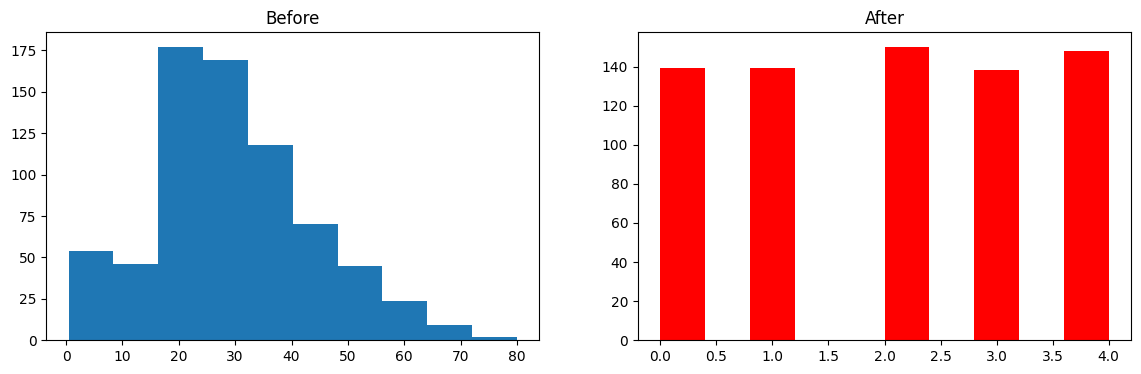

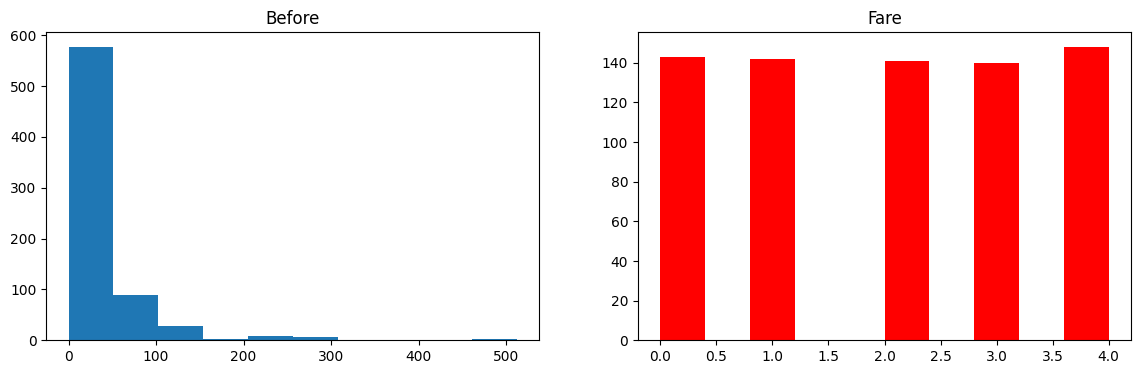

In [31]:
discretize(5,'quantile')

# applying kmeans binning

In [32]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    
    trf = ColumnTransformer([
        ('first',kbin_age,[0]),
        ('second',kbin_fare,[1])
    ])
    
    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()
    

0.6345070422535211


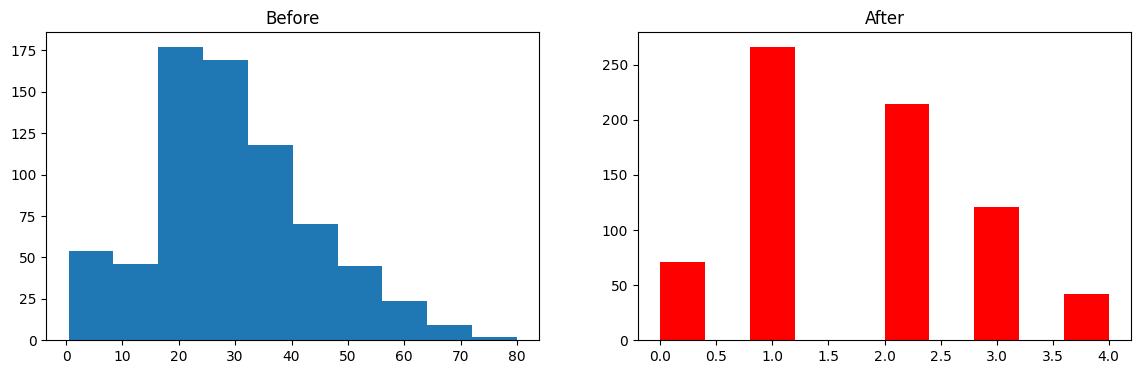

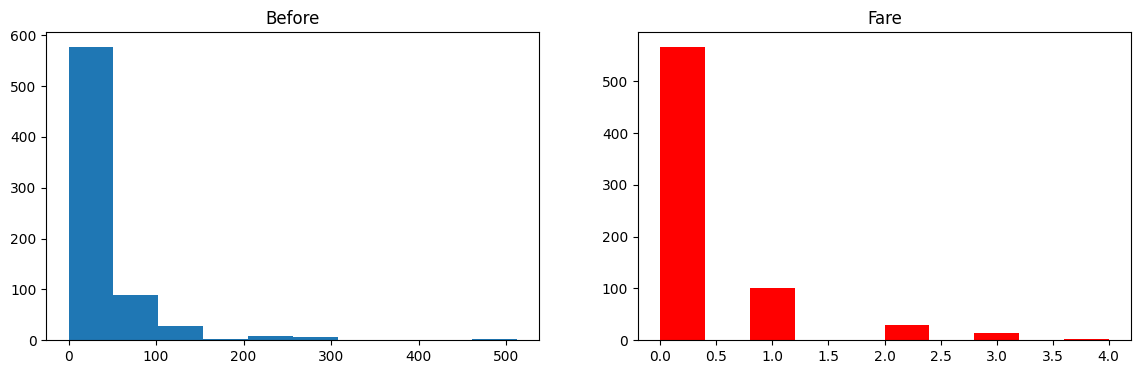

In [33]:
discretize(5,'kmeans')  # takes times